# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

#### Mount Drive

In [5]:
import google.colab.drive as drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [6]:
# define a function to load json file to a dataframe
def load_json_to_dataframe(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        return df
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return pd.DataFrame()

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [7]:
# read the json file by giving the file path and create a dataframe
df = load_json_to_dataframe('drive/MyDrive/ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [8]:
# display first five rows of the dataframe - df
df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [9]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [10]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [19]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x:x.split())
# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x:x.split())

print(df[['input_tokens','pos_tokens']].head())

                                                                                                                                                                                                                                                                                                                                    input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, 

In [20]:
# display first five rows of the dataframe - df
df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [21]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [22]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]

# Displaying rows with mismatched lengths, if any.
print("Rows with unequal input and POS token lengths:")
unequal_rows[['input', 'pos', 'input_length', 'pos_length']]

Rows with unequal input and POS token lengths:


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient            37          36
79                                                                                              1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt                                                                                                                                                                    quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient            38          37
164  1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled  quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [23]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
# Define a function to get unique POS labels
def unique_labels(df):
    # Flatten all POS tokens from each row and convert to a set to get unique labels
    all_labels = set(label for row in df['pos_tokens'] for label in row)
    return all_labels

unique_pos_labels = unique_labels(df)
print("Unique POS labels in the dataset:")
print(unique_pos_labels)

Unique POS labels in the dataset:
{'unit', 'ingredient', 'quantity'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


* Based on observations from the previous validation (2.2.2), we discovered rows where the input_tokens and pos_tokens were not matching. This indicates that the POS tagging in those rows is not entirely in line with the tokens. These discrepancies frequently indicate missing tags or formatting problems.

* Findings from the Validation of Recipe Data :-

   * Only three labels—"quantity," "unit," and "ingredient"—are used in the POS tagging, which is largely consistent.

   * A few rows have token mismatches, which are probably caused by additional whitespace, missing POS tags, or inconsistent formatting in the original data.

   * According to your result, there were only 5 rows with mismatched token lengths in the total dataset.

* The following indexes need to be cleaned and formatted: [17, 27, 79, 164, 207]

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [25]:
# drop the irrelevant recipe data
df = df[df['input_length'] == df['pos_length']].reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [26]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Display the updated shape and a few rows to confirm
print(df.shape)
df[['input_length', 'pos_length']].head()

(280, 6)


input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [36]:
# validate the input length and pos length as input_length and pos_length
unequal_rows = df[df['input_length'] != df['pos_length']]

print(f"Number of rows with unequal input_length and pos_length: {unequal_rows.shape[0]}")
display(unequal_rows)

Number of rows with unequal input_length and pos_length: 0


Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length]
Index: []

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [30]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Spliting the dataset into training (70%) and validation (30%) sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [31]:
# print the first five rows of train_df
print(train_df.head())

                                                                                                                                                                                                                                                           input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                       

In [32]:
# print the first five rows of the val_df
print(val_df.head())

                                                                                                                                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                 

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [33]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [35]:
# validate the shape of training and validation samples
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of y_val: {len(y_val)}")

Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [37]:
# Display the number of unique labels present in y_train
# Flatten y_train
flat_y_train = [label for sublist in y_train for label in sublist]

# Calculate the number of unique labels
unique_labels = np.unique(flat_y_train)
print("Number of unique labels in y_train:", len(unique_labels))

# Display the number of unique labels
len(unique_labels), unique_labels

Number of unique labels in y_train: 3


(3, array(['ingredient', 'quantity', 'unit'], dtype='<U10'))

## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [39]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

In [40]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [41]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)

def extract_and_validate_tokens(df, dataset_name):
    # call the flatten_list and apply it on input_tokens and pos_tokens
    flat_input_tokens = flatten_list(df['input_tokens'])
    flat_pos_tokens = flatten_list(df['pos_tokens'])

    # Validate the lengths of flattened tokens
    print(f"{dataset_name} - Length of input_tokens:", len(flat_input_tokens))
    print(f"{dataset_name} - Length of pos_tokens:", len(flat_pos_tokens))

    # Display first 10 records of input_tokens and pos_tokens
    print(f"\n{dataset_name} - First 10 input_tokens:", flat_input_tokens[:10])
    print(f"{dataset_name} - First 10 pos_tokens:", flat_pos_tokens[:10])

In [42]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, "Training")
extract_and_validate_tokens(val_df, "Validation")

Training - Length of input_tokens: 7114
Training - Length of pos_tokens: 7114

Training - First 10 input_tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
Training - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Validation - Length of input_tokens: 2876
Validation - Length of pos_tokens: 2876

Validation - First 10 input_tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
Validation - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [46]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
def categorize_tokens(input_tokens, pos_tokens):
    # Initialize empty lists for ingredients, units, and quantities
    ingredients = []
    units = []
    quantities = []

    # Iterate through the tokens and categorize them based on the POS tag
    for token, pos in zip(input_tokens, pos_tokens):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)

    # Return the categorized lists
    return ingredients, units, quantities


# validate the list that it comprised of these labels, if not return empty arrays
# We'll modify this function so that it also calls the categorize_tokens function within it and then returns the categorized lists (ingredients, units, quantities) as part of the output.
def extract_and_validate_tokens_updated(dataframe, dataset_name):
    # Flatten the input_tokens and pos_tokens
    flat_input_tokens = flatten_list(dataframe['input_tokens'].tolist())
    flat_pos_tokens = flatten_list(dataframe['pos_tokens'].tolist())

    # Print lengths for validation
    print(f"{dataset_name} - Length of input_tokens:", len(flat_input_tokens))
    print(f"{dataset_name} - Length of pos_tokens:", len(flat_pos_tokens))

    # Display first 10 records of input_tokens and pos_tokens
    print(f"\n{dataset_name} - First 10 input_tokens:", flat_input_tokens[:10])
    print(f"{dataset_name} - First 10 pos_tokens:", flat_pos_tokens[:10])

    # Categorize tokens into ingredients, units, and quantities
    ingredients, units, quantities = categorize_tokens(flat_input_tokens, flat_pos_tokens)

    # Return the categorized lists
    return ingredients, units, quantities


In [47]:
#  call the function to categorise the labels into respective list

# Training
train_ingredients, train_units, train_quantities = extract_and_validate_tokens_updated(train_df, "Training")

# Validation
val_ingredients, val_units, val_quantities = extract_and_validate_tokens_updated(val_df, "Validation")

Training - Length of input_tokens: 7114
Training - Length of pos_tokens: 7114

Training - First 10 input_tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
Training - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Validation - Length of input_tokens: 2876
Validation - Length of pos_tokens: 2876

Validation - First 10 input_tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
Validation - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [48]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name):
    item_counter = Counter(item_list)  # Count the frequency of each item
    most_common_items = item_counter.most_common(10)  # Get the top 10 most frequent items

    print(f"Top 10 {pos_label}s in the {dataset_name} dataset:")
    for item, count in most_common_items:
        print(f"{item}: {count}")

In [49]:
# get the top ingredients which are frequently seen in the recipe

# Training dataset
get_top_frequent_items(train_units, "unit", "Training")


# Validation dataset
get_top_frequent_items(val_ingredients, "ingredient", "Validation")

Top 10 units in the Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39
Top 10 ingredients in the Validation dataset:
powder: 54
Salt: 47
Oil: 39
Red: 39
seeds: 36
Chilli: 36
chopped: 31
Green: 30
Leaves: 29
Coriander: 27


In [50]:
# get the top units which are frequently seen in the recipe

# Training dataset
get_top_frequent_items(train_units, "unit", "Training")

# Validation dataset
get_top_frequent_items(val_units, "unit", "Validation")

Top 10 units in the Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39
Top 10 units in the Validation dataset:
teaspoon: 59
cup: 57
tablespoon: 32
tablespoons: 32
cups: 24
sprig: 21
inch: 20
grams: 19
teaspoons: 18
cloves: 16


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [51]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt

def plot_top_items(top_items, label, dataset_name):
    items, counts = zip(*top_items)
    plt.figure(figsize=(8, 4))
    plt.bar(items, counts)
    plt.title(f"Top 10 {label.title()}s in {dataset_name} Set")
    plt.xlabel(label.title())
    plt.ylabel("Frequency")
    plt.xticks(rotation=50, ha="right")
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



Training - Length of input_tokens: 7114
Training - Length of pos_tokens: 7114

Training - First 10 input_tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
Training - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Top 10 ingredients in the Training dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65
Top 10 units in the Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


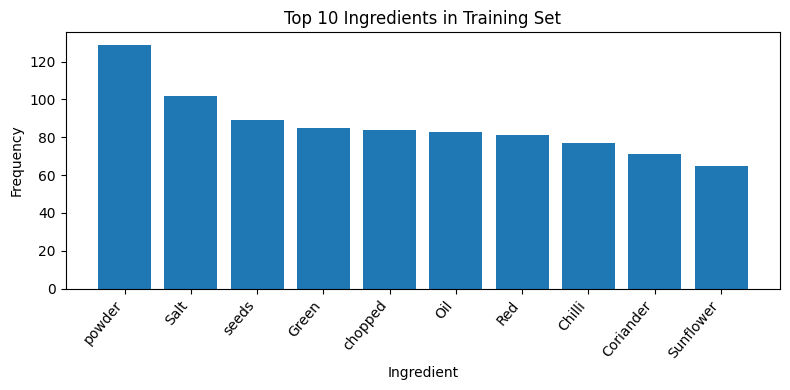

In [56]:
# plot the top frequent ingredients in training data

# 1. Extract & categorize tokens for the training set
train_ingredients, train_units, train_quantities = extract_and_validate_tokens_updated(train_df, "Training")

# 2. Compute the Top-10 most frequent ingredients
top_ingredients_train = Counter(train_ingredients).most_common(10)
top_units_train = Counter(train_units).most_common(10)

# 3. View the result
print("Top 10 ingredients in the Training dataset:")
for ingredient, freq in top_ingredients_train:
    print(f"{ingredient}: {freq}")

print("Top 10 units in the Training dataset:")
for unit, freq in top_units_train:
    print(f"{unit}: {freq}")

plot_top_items(top_ingredients_train, 'ingredient', 'Training')

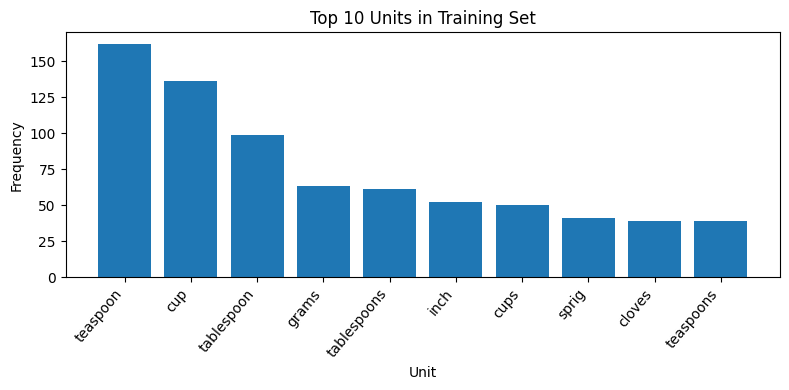

In [57]:
# plot top-10 units in Training data
plot_top_items(top_units_train, 'unit', 'Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [58]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    'teaspoon', 'teaspoons', 'tsp', 'tsp.', 'tablespoon', 'tablespoons', 'tbsp', 'tbsp.', 'cup', 'cups','ml', 'milliliter', 'milliliters', 'l', 'litre', 'litres',
    'g', 'gram', 'grams', 'kg', 'kilogram', 'kilograms','oz', 'ounce', 'ounces', 'lb', 'pound', 'pounds','pinch', 'dash', 'drop', 'clove', 'cloves', 'stick', 'sticks', 'can', 'cans', 'slice', 'slices', 'packet', 'packets'
}

quantity_keywords = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten','half', 'quarter', 'third', 'whole', 'dozen', 'double','1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
    '1/2', '1/4', '3/4', '2/3', '1/3', '¾', '¼', '½','0.5', '0.25', '0.75', '0.33', '0.66'
}
# Regex to match integers, decimals or simple fractions like 1/2, 3-1/2
quantity_pattern = re.compile(r"""^(
    \d+             |   # integer
    \d+\.\d+        |   # decimal
    \d+/\d+         |   # simple fraction
    \d+-\d+/\d+         # mixed fraction e.g. 1-1/2
)$""", re.VERBOSE)

In [59]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [60]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---

def word2features(sent, i):
    doc = nlp(" ".join(sent))  # Parse full sentence once
    tok = doc[i]

    # --- Core Features ---
    features = {
        "bias": 1.0,
        "token": tok.text.lower(),
        "lemma": tok.lemma_.lower(),
        "pos_tag": tok.pos_,
        "tag": tok.tag_,
        "dep": tok.dep_,
        "shape": tok.shape_,
        "is_stop": tok.is_stop,
        "is_digit": tok.is_digit,
        "has_digit": any(ch.isdigit() for ch in tok.text),
        "has_alpha": any(ch.isalpha() for ch in tok.text),
        "hyphenated": "-" in tok.text,
        "slash_present": "/" in tok.text,
        "is_title": tok.is_title,
        "is_upper": tok.is_upper,
        "is_punct": tok.is_punct,
    }

    # --- Improved Quantity & Unit Detection ---
    features.update({
        "is_quantity": tok.text.lower() in quantity_keywords or bool(quantity_pattern.match(tok.text)),
        "is_unit": tok.text.lower() in unit_keywords,
        "is_numeric": tok.text.replace("-", "").replace("/", "").replace(".", "").isdigit(),
        "is_fraction": "/" in tok.text,
        "is_decimal": bool(re.match(r"^\d+\.\d+$", tok.text)),
        "preceding_word": sent[i - 1].lower() if i > 0 else None,
        "following_word": sent[i + 1].lower() if i < len(sent) - 1 else None,
    })

    # --- Named Entity Recognition (NER) ---
    features["named_entity"] = tok.ent_type_ if tok.ent_type_ else "None"

    # --- Dependency-Based Features (Fixed Missing Child Issue) ---
    first_child = next(iter(tok.children), None)  # Extract first child safely

    features.update({
        "parent_dep": tok.head.dep_,
        "parent_pos": tok.head.pos_,
        "grandparent_dep": tok.head.head.dep_ if tok.head.head != tok.head else "None",
        "grandparent_pos": tok.head.head.pos_ if tok.head.head != tok.head else "None",
        "num_children": len(list(tok.children)),
        "first_child_dep": first_child.dep_ if first_child else "None",  # Avoid NoneType error
        "first_child_pos": first_child.pos_ if first_child else "None",  # Avoid NoneType error
        "ancestor_dep": list(tok.ancestors)[0].dep_ if list(tok.ancestors) else "None",

    })

    # --- Contextual Features ---
    if i == 0:
        features["BOS"] = True
    else:
        prev = doc[i - 1]
        features.update({
            "prev_token": prev.text.lower(),
            "prev_is_quantity": prev.text.lower() in quantity_keywords or bool(quantity_pattern.match(prev.text)),
            "prev_is_digit": prev.is_digit,
        })

    if i == len(doc) - 1:
        features["EOS"] = True
    else:
        nxt = doc[i + 1]
        features.update({
            "next_token": nxt.text.lower(),
            "next_is_unit": nxt.text.lower() in unit_keywords,
            "next_is_ingredient": (nxt.text.lower() not in unit_keywords and nxt.text.lower() not in quantity_keywords),
        })

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [64]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(labels):
    return labels  # a list of tags per token

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [63]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_feats = [sent2features(s) for s in X_train]
y_train_labels = [sent2labels(l) for l in y_train]

X_val_feats = [sent2features(s) for s in X_val]
y_val_labels = [sent2labels(l) for l in y_val]

# Display check
print(len(X_train_feats), len(y_train_labels))
print(len(X_val_feats),   len(y_val_labels))

196 196
84 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [65]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(labels) for labels in y_train]
y_val_labels   = [list(labels) for labels in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [66]:
# print the length of train features and labels
print(f"Number of training label sequences: {len(y_train_labels)}")
print(f"Number of validation label sequences: {len(y_val_labels)}")

Number of training label sequences: 196
Number of validation label sequences: 84


In [68]:
# print the length of validation features and labels
print(f"training feature length = {len(X_train_feats)}")
print(f"training label length = {len(y_train_labels)}")
print(f"validation feature length = {len(X_val_feats)}")
print(f"validation label length = {len(y_val_labels)}")

training feature length = 196
training label length = 196
validation feature length = 84
validation label length = 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [69]:
# Flatten labels in y_train
y_train_flat = [label for seq in y_train_labels for label in seq]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [70]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
# Count the frequencies of each label in y_train_flat
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

# Display label counts and total samples
print("Label Counts:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")

print(f"\nTotal samples (tokens) in y_train_flat: {total_samples}")

Label Counts:
  quantity: 980
  unit: 811
  ingredient: 5323

Total samples (tokens) in y_train_flat: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [71]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}

for label, count in label_counts.items():
    # Inverse frequency
    weight_dict[label] = total_samples / (count if count else 1)

In [72]:
# penalise ingredient label
weight_dict['ingredient'] *= 1.5
print("Computed class weights:")
for label, weight in weight_dict.items():
    print(f"  {label}: {weight:.4f}")

Computed class weights:
  quantity: 7.2592
  unit: 8.7719
  ingredient: 2.0047


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [73]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X_train, y_train, X_val, y_val, weight_dict):

    # Feature extraction for training dataset
    X_train_feats = [sent2features(s) for s in X_train]
    y_train_labels = [sent2labels(l) for l in y_train]

    # Feature extraction for validation dataset
    X_val_feats = [sent2features(s) for s in X_val]
    y_val_labels = [sent2labels(l) for l in y_val]

    # Apply class weights to labels in training data
    weighted_y_train = []
    for sequence in y_train_labels:
        weighted_sequence = [weight_dict.get(label, 1.0) for label in sequence]  # Default weight = 1.0
        weighted_y_train.append(weighted_sequence)

    # Apply class weights to labels in validation data
    weighted_y_val = []
    for sequence in y_val_labels:
        weighted_sequence = [weight_dict.get(label, 1.0) for label in sequence]
        weighted_y_val.append(weighted_sequence)

    # Apply class weights to features
    for dataset_feats, dataset_labels in zip([X_train_feats, X_val_feats], [y_train_labels, y_val_labels]):
        for i, sentence_features in enumerate(dataset_feats):
            for j, feature_dict in enumerate(sentence_features):
                label = dataset_labels[i][j]
                feature_dict["bias"] = feature_dict.get("bias", 1.0) * weight_dict.get(label, 1.0)  # Apply class weight

    return X_train_feats, y_train_labels, weighted_y_train, X_val_feats, y_val_labels, weighted_y_val


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [74]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels, y_train_weights, X_val_weighted_features, y_val_weighted_labels, y_val_weights = extract_features_with_class_weights(
    X_train, y_train, X_val, y_val, weight_dict
)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [75]:
# initialise CRF model with the specified hyperparameters and use weight_dict
from sklearn_crfsuite import CRF
crf_model = CRF(
    algorithm='lbfgs',           # Optimization algorithm
    c1=0.5,                      # L1 regularization coefficient
    c2=0.1,                      # L2 regularization coefficient
    max_iterations=100,         # Maximum iterations
    all_possible_transitions=True,
    # class_weights=weight_dict   # Set your label weights here
)

def apply_class_weights(features, labels, weight_dict):
    weighted_features = []

    for i in range(len(features)):
        weighted_feature = []
        for feature, label in zip(features[i], labels[i]):
            weight = weight_dict.get(label, 1)  # Default weight is 1 if label is not found in weight_dict
            # Check if the feature is a dict or numeric, and extract the numeric value if it's a dict
            if isinstance(feature, dict):
                # Assuming each feature dict has a key 'value' or similar for numeric values
                feature_value = feature.get('value', 0)  # Replace 'value' with your actual key name
                weighted_feature.append({'value': feature_value * weight})  # Keep as a dictionary
            else:
                weighted_feature.append(feature * weight)  # If feature is numeric, multiply directly

        weighted_features.append(weighted_feature)

    return weighted_features

# train the CRF model with the weighted training data
X_train_weighted_features_updated = apply_class_weights(X_train_weighted_features, y_train_weighted_labels, weight_dict)
crf_model.fit(X_train_weighted_features_updated, y_train_weighted_labels)



CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=0.1,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [76]:
# evaluate on the training dataset
y_pred_train = crf_model.predict(X_train_weighted_features_updated)
print(flat_classification_report(y_train_weighted_labels, y_pred_train))

              precision    recall  f1-score   support

  ingredient       0.78      0.99      0.87      5323
    quantity       1.00      0.20      0.33       980
        unit       0.71      0.17      0.28       811

    accuracy                           0.79      7114
   macro avg       0.83      0.45      0.49      7114
weighted avg       0.80      0.79      0.73      7114



In [77]:
# specify the flat classification report by using training data for evaluation
from itertools import chain
from sklearn.metrics import classification_report

y_true_flat = list(chain.from_iterable(y_train_weighted_labels))  # Flatten true labels
y_pred_flat = list(chain.from_iterable(y_pred_train))  # Flatten predicted labels
print(classification_report(y_true_flat, y_pred_flat))

              precision    recall  f1-score   support

  ingredient       0.78      0.99      0.87      5323
    quantity       1.00      0.20      0.33       980
        unit       0.71      0.17      0.28       811

    accuracy                           0.79      7114
   macro avg       0.83      0.45      0.49      7114
weighted avg       0.80      0.79      0.73      7114



In [78]:
# create a confusion matrix on training datset
cm = confusion_matrix(y_true_flat, y_pred_flat)
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for CRF Model")
plt.show()

[[5268    0   55]
 [ 782  196    2]
 [ 672    0  139]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [80]:
# dump the model using joblib as crf_model.pkl
import joblib

# Save the trained CRF model
joblib.dump(crf_model, "crf_model.pkl")
print("Model saved as crf_model.pkl")
# Load the saved CRF model
crf_loaded = joblib.load("crf_model.pkl")
print("Model loaded successfully!")

Model saved as crf_model.pkl
Model loaded successfully!


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [81]:
# predict the crf model on validation dataset
def replace_none_with_default(features, default_value=0.0):
    """
    Recursively replace None values in the feature data with a default value.
    """
    if isinstance(features, list):
        return [replace_none_with_default(f, default_value) for f in features]
    elif isinstance(features, dict):
        return {key: replace_none_with_default(val, default_value) for key, val in features.items()}
    elif features is None:
        return default_value
    else:
        return features

# Apply this function to clean the validation data
X_val_weighted_features_cleaned = replace_none_with_default(X_val_weighted_features)

# After cleaning, ensure there are no remaining None values in the features
def check_for_none(features):
    for i, seq in enumerate(features):
        for j, feature in enumerate(seq):
            if feature is None:
                print(f"None found at index ({i}, {j})")
                return True
    return False

# Check validation features for None values after cleaning
if check_for_none(X_val_weighted_features_cleaned):
    print("There are still None values in the validation features!")
else:
    print("No None values found in the validation features.")

# Predict on the cleaned validation set
y_pred_val = crf_model.predict(X_val_weighted_features_cleaned)


No None values found in the validation features.


In [84]:
# specify flat classification report
from itertools import chain
from sklearn.metrics import classification_report

y_val_true_flat = list(chain.from_iterable(y_val_weighted_labels))  # Flatten true labels
y_val_pred_flat = list(chain.from_iterable(y_pred_val))  # Flatten predicted labels
print(classification_report(y_val_true_flat, y_val_pred_flat))

              precision    recall  f1-score   support

  ingredient       0.77      0.99      0.86      2107
    quantity       1.00      0.20      0.34       411
        unit       0.69      0.16      0.26       358

    accuracy                           0.77      2876
   macro avg       0.82      0.45      0.49      2876
weighted avg       0.79      0.77      0.71      2876



[[5268    0   55]
 [ 782  196    2]
 [ 672    0  139]]


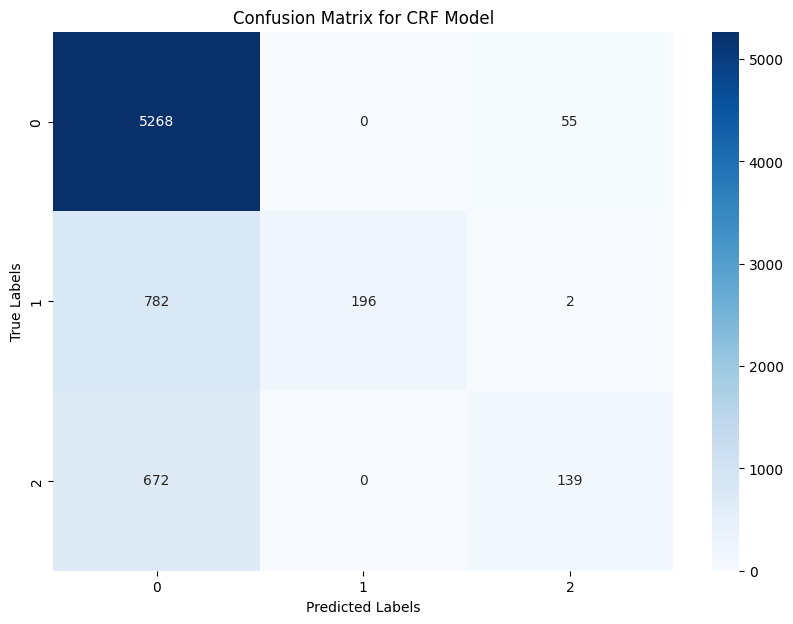

In [85]:
# create a confusion matrix on validation dataset
cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat)
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for CRF Model")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [86]:
# flatten Labels and Initialise Error Data

# flatten
y_val_flat = [label for seq in y_val_weighted_labels for label in seq]
y_pred_flat = [label for seq in y_pred_val for label in seq]
# Initialize error data to track mismatches between true and predicted labels
error_data = []

# Compare and log errors where mismatches occur
for true_label, pred_label in zip(y_val_flat, y_pred_flat):
    if true_label != pred_label:
        error_data.append((true_label, pred_label))

# Optionally, print the error data to inspect mismatches
print("Number of errors:", len(error_data))
print("Error data (True label, Predicted label):", error_data[:10])  # Print the first 10 errors for inspection

Number of errors: 653
Error data (True label, Predicted label): [('quantity', 'ingredient'), ('unit', 'ingredient'), ('quantity', 'ingredient'), ('unit', 'ingredient'), ('quantity', 'ingredient'), ('unit', 'ingredient'), ('ingredient', 'unit'), ('quantity', 'ingredient'), ('quantity', 'ingredient'), ('unit', 'ingredient')]


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [87]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases

for i, (features, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
    for j, (true_label, pred_label) in enumerate(zip(true_labels, pred_labels)):

        # Check if there is an error (mismatch between true and predicted labels)
        if true_label != pred_label:
            # Get the current token and its features
            current_token = features[j]

            # Handle boundary cases for previous and next tokens
            previous_token = X_val[i][j-1] if j > 0 else None  # Get previous token, if available
            next_token = X_val[i][j+1] if j < len(true_labels) - 1 else None  # Get next token, if available

            # Get the class weight (use a default weight of 1 if not found in weight_dict)
            weight = weight_dict.get(true_label, 1.0)

            # Collect error information
            error_info = {
                'index': i,  # Index of the sequence
                'token': current_token,  # Current token (where the error occurred)
                'true_label': true_label,  # True label
                'predicted_label': pred_label,  # Predicted label
                'previous_token': previous_token,  # Previous token
                'next_token': next_token,  # Next token
                'weight': weight  # Class weight
            }

            # Add the error information to the error_data list
            error_data.append(error_info)

# Optional: Print some error details for inspection
print(f"Total number of errors: {len(error_data)}")
print("Sample error data (first 5 errors):", error_data[:5])

Total number of errors: 1306
Sample error data (first 5 errors): [('quantity', 'ingredient'), ('unit', 'ingredient'), ('quantity', 'ingredient'), ('unit', 'ingredient'), ('quantity', 'ingredient')]


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [88]:
# Create DataFrame and Print Overall Accuracy

# Convert the error_data into a pandas DataFrame
error_df = pd.DataFrame(error_data)

# Flatten the true and predicted labels from validation data to compute accuracy
flattened_true_labels = [label for sublist in y_val_labels for label in sublist]
flattened_pred_labels = [label for sublist in y_pred_val for label in sublist]

# Calculate accuracy: number of correct predictions / total predictions
correct_predictions = sum([1 for true, pred in zip(flattened_true_labels, flattened_pred_labels) if true == pred])
total_predictions = len(flattened_true_labels)

accuracy = correct_predictions / total_predictions
print(f"Overall accuracy on the validation set: {accuracy * 100:.2f}%")

Overall accuracy on the validation set: 77.29%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [89]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

import pandas as pd
from collections import defaultdict

# Flatten the true and predicted labels
flattened_true_labels = [label for seq in y_val_weighted_labels for label in seq]
flattened_pred_labels = [label for seq in y_pred_val for label in seq]

# Flatten X_val as well (preserving sequence order)
X_val_flattened = [token for seq in X_val for token in seq]

# Initialize token index for error collection
token_index = 0
errors_by_label = defaultdict(list)

# Iterate through validation data and collect errors
true_index = 0  # Iterator for flattened_true_labels
for sequence_index, sequence in enumerate(X_val):  # Iterate over sequences in X_val
    for token_index_in_seq, token in enumerate(sequence):  # Iterate over tokens in each sequence
        # Get the corresponding true and predicted labels for the current token
        true_label = flattened_true_labels[true_index]
        pred_label = flattened_pred_labels[true_index]

        # Get the previous and next tokens, handling boundaries
        prev_token = sequence[token_index_in_seq - 1] if token_index_in_seq > 0 else None
        next_token = sequence[token_index_in_seq + 1] if token_index_in_seq < len(sequence) - 1 else None

        if true_label != pred_label:  # Only collect errors
            weight = weight_dict.get(true_label, 1)  # Get the class weight (default to 1 if not found)

            # Collect the error information
            errors_by_label[true_label].append({
                'token': token,
                'prev_token': prev_token,
                'next_token': next_token,
                'true_label': true_label,
                'pred_label': pred_label,
                'weight': weight
            })

        # Move to the next token in flattened sequence
        true_index += 1

# Convert errors_by_label into DataFrame for better visualization
error_data = []
for label, errors in errors_by_label.items():
    for error in errors:
        error_data.append(error)

error_df = pd.DataFrame(error_data)

# Display the first few rows of the error DataFrame
print(error_df.head())

# Calculate accuracy per label
label_accuracy = {}
total_labels = len(flattened_true_labels)

for label in weight_dict.keys():
    correct = sum([1 for true, pred in zip(flattened_true_labels, flattened_pred_labels) if true == pred and true == label])
    total = sum([1 for true in flattened_true_labels if true == label])

    if total > 0:
        accuracy = correct / total
    else:
        accuracy = 0
    label_accuracy[label] = accuracy

# Display accuracy by label
for label, accuracy in label_accuracy.items():
    weight = weight_dict.get(label, 1)
    print(f"Label: {label}, Accuracy: {accuracy * 100:.2f}%, Weight: {weight}")

  token prev_token next_token true_label  pred_label    weight
0     2        Ada      liter   quantity  ingredient  7.259184
1   3/4       Milk      Sugar   quantity  ingredient  7.259184
2   1/2       Ghee   teaspoon   quantity  ingredient  7.259184
3     7    chopped   Potatoes   quantity  ingredient  7.259184
4     2       Aloo       cups   quantity  ingredient  7.259184
Label: quantity, Accuracy: 20.44%, Weight: 7.259183673469388
Label: unit, Accuracy: 16.20%, Weight: 8.771886559802713
Label: ingredient, Accuracy: 98.77%, Weight: 2.0046965996618447


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>
 1. Excellent Results with Ingredients
The model successfully recognizes tokens related to ingredients, as evidenced by the excellent accuracy of the ingredient label (98.77%).

Ingredients have a lower weight (2.00), indicating that they are naturally well-represented and don't need as much attention.

2. Inadequate Identification of Unit and Quantity Labels
Despite having a high weight (7.26), the quantity label has poor accuracy (20.44%). This suggests that although the model prioritizes words related to quantity, it finds it difficult to distinguish them from other labels.

Despite having an even higher weight (8.77), the unit label accuracy is even worse (16.20%), indicating that the model is not able to accurately distinguish units.

3. Quantity labels are routinely mislabeled as ingredients.
Tokens like "2," "3/4", "1/2", "7", and "2" were anticipated to represent ingredients but were actually supposed to be quantities.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

#### This implies that during training, numerical tokens may be too correlated with words that are related to ingredients.